In [6]:
# conda install -c numba numba
# conda install -c omnia parmed
# conda install -c conda-forge mdtraj
# conda install -c pytorch pytorch
# conda install -c conda-forge tqdm
import os
import sys
import numpy as np
import pandas as pd
import mdtraj as md
import parmed as pmd
import matplotlib.pyplot as plt
import numba  # njit, prange

sys.path.append(os.path.expanduser('~/masif_my/source'))

import mdtraj_utils as mdu
import mdtraj_utils.trajectory_utils as mdu_traj
import my_utils as my
import data_preparation.extract_and_triangulate_lib as ext_and_trg

# setup data connector
dc = mdu.data.DataConnector("database", safe=True)

## Input parameters

PDB Ids: 1AK4, 1CGI, 1E96, 1FLE, 1GPW, 1JTG, 1R0R, 1R6Q, 1RKE, 1Z0K, 1ZHH, 2HQS, 2I25, 2O3B, 2OOB, 3F1P

MD Ids:
* uR: unbound conformation of the receptor
* uL: unbound conformation of the ligand
* C: structure of the bound complex (R+L)
* bR: bound conformation of the receptor taken from the structure of the complex (C)
* bL: bound conformation of the ligand taken from the structure of the complex (C)
* sepB: seperatated (~10A) complex
* sepU: seperatated (~10A) complex but swaping the subunits with the unbound conformations

## Load data

In [7]:
pdb_id = '1Z0K'
md_runs = ['C', 'uR', 'uL', 'bR']

In [8]:
for md_id in md_runs:
    dc.load_trajectory(pdb_id, md_id)
    dc.load_reference(pdb_id, md_id)
    dc.load_info(pdb_id, md_id)
    print(dc[pdb_id][md_id])

{'info': {'pdbid': '1Z0K', 'mdid': 'C', 'rid': '1', 'prmtop_filepath': 'raw_data/data/rep1/1Z0K/C/prmtop', 'inpcrd_filepath': 'raw_data/data/rep1/1Z0K/C/inpcrd', 'MODIFIED': '2020-07-08_09:58:36'}, 'traj': <mdtraj.Trajectory with 50101 frames, 3691 atoms, 232 residues, and unitcells at 0x7ff602f8d358>, 'traj_ref': <mdtraj.Trajectory with 1 frames, 3691 atoms, 232 residues, and unitcells at 0x7ff6027e0ef0>}
{'info': {'pdbid': '1Z0K', 'mdid': 'uR', 'rid': '1', 'prmtop_filepath': 'raw_data/data/rep1/1Z0K/uR/prmtop', 'inpcrd_filepath': 'raw_data/data/rep1/1Z0K/uR/inpcrd', 'MODIFIED': '2020-07-08_09:58:47'}, 'traj': <mdtraj.Trajectory with 50101 frames, 2736 atoms, 171 residues, and unitcells at 0x7ff602882ac8>, 'traj_ref': <mdtraj.Trajectory with 1 frames, 2736 atoms, 171 residues, and unitcells at 0x7ff6023a8fd0>}
{'info': {'pdbid': '1Z0K', 'mdid': 'uL', 'rid': '1', 'prmtop_filepath': 'raw_data/data/rep1/1Z0K/uL/prmtop', 'inpcrd_filepath': 'raw_data/data/rep1/1Z0K/uL/inpcrd', 'MODIFIED': 

In [20]:
uL_trj = dc[pdb_id]['uL']['traj']
uR_trj = dc[pdb_id]['uR']['traj']
C_trj = dc[pdb_id]['C']['traj']

In [60]:
frame_i = 24300
def save_named_pdb(dc, pdb_id, md_id, frame_i):
    dc[pdb_id][md_id]['traj'][frame_i].save(os.path.join('-'.join([pdb_id, md_id, str(frame_i)]) + '.pdb'))
    
for md_id in md_runs:
    save_named_pdb(dc, pdb_id, md_id, frame_i)


In [10]:
uR_traj = dc[pdb_id]['uR']['traj']
bR_traj = dc[pdb_id]['bR']['traj']
main_chain_atom_ids = mdu_traj.chain_atom_indices(uR_traj, 0)
rmsd_self = md.rmsd(uR_traj, uR_traj, frame=0, atom_indices=main_chain_atom_ids)
rmsd_ub = md.rmsd(uR_traj, bR_traj, frame=0, atom_indices=main_chain_atom_ids)

these frames were not found:

10 worst cases:
frame 24300 : ROCAUC =  0.6114996405463695
frame 1500 : ROCAUC =  0.619061095300157
frame 28450 : ROCAUC =  0.659316819185863
frame 20250 : ROCAUC =  0.6748578305041426
frame 17600 : ROCAUC =  0.6809941550225082
frame 15000 : ROCAUC =  0.6865985386331334
frame 31200 : ROCAUC =  0.6913640674394099
frame 2050 : ROCAUC =  0.6933823335803407
frame 16300 : ROCAUC =  0.6978614390513576
frame 1750 : ROCAUC =  0.6989044931902075


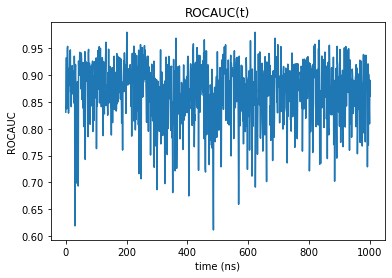

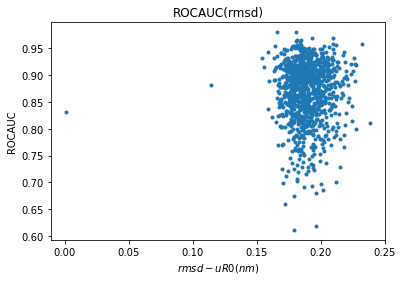

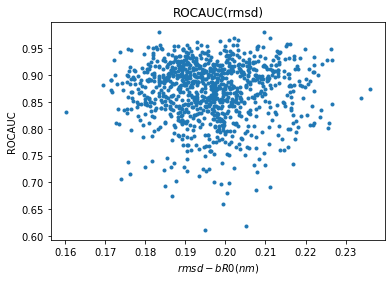

In [11]:
pdb_dir = 'PDBS'
step = 50

traj_id = '-'.join([pdb_id, 'uR'])

data = np.loadtxt(os.path.join(pdb_dir, traj_id + '.dat'))
frames_ids = np.intc(data[:, 0])
roc_auc = data[:, 1]
min_acc = np.argmin(roc_auc)
time = frames_ids * 0.02

uR_traj = dc[pdb_id]['uR']['traj']
N_frames = uR_traj.n_frames
rmsd_self_picked = rmsd_self[frames_ids]
rmsd_ub_picked = rmsd_ub[frames_ids]

print('these frames were not found:')
for f_i in range(0, N_frames, step):
    if(not f_i in frames_ids):
        print(f_i)
        
sorted_frames_ids = sorted(enumerate(frames_ids), key=lambda f_i: roc_auc[f_i[0]])
N_worst_cases = 10
print('\n' + str(N_worst_cases) + ' worst cases:')
for i in range(N_worst_cases):
    print('frame', sorted_frames_ids[i][1], ': ROCAUC = ', roc_auc[sorted_frames_ids[i][0]])

fig_time, ax_time = my.get_fig('time (ns)', 'ROCAUC', title='ROCAUC(t)')
ax_time.plot(time, roc_auc)

fig_rmsd_self, ax_rmsd_self = my.get_fig('$rmsd - uR0 (nm)$', 'ROCAUC', title='ROCAUC(rmsd)')
ax_rmsd_self.plot(rmsd_self_picked, roc_auc, '.')

fig_rmsd_ub, ax_rmsd_ub = my.get_fig('$rmsd - bR0 (nm)$', 'ROCAUC', title='ROCAUC(rmsd)')
ax_rmsd_ub.plot(rmsd_ub_picked, roc_auc, '.')

Text(0, 0.5, 'rmsd uR-bR (nm)')

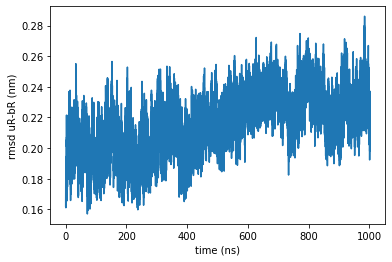

In [113]:
plt.plot(np.arange(N_frames) * 0.02, rmsd_uR_bR_superposed_chainA)
plt.xlabel('time (ns)')
plt.ylabel('rmsd uR-bR (nm)')

Text(0, 0.5, 'rmsd uR-uR0 (nm)')

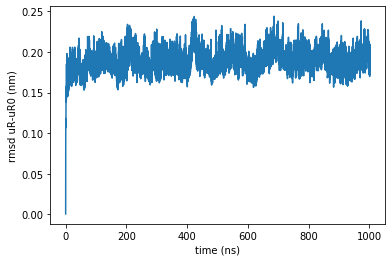

In [114]:
plt.plot(np.arange(N_frames) * 0.02, rmsd_uR_uR0_chainA)
plt.xlabel('time (ns)')
plt.ylabel('rmsd uR-uR0 (nm)')

Text(0, 0.5, 'rmsd bR-bR0 (nm)')

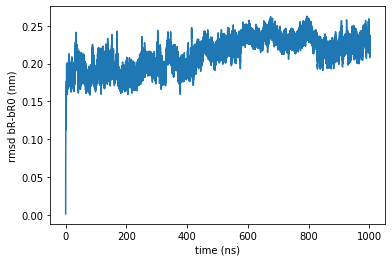

In [115]:
plt.plot(np.arange(N_frames) * 0.02, rmsd_bR_bR0_chainA)
plt.xlabel('time (ns)')
plt.ylabel('rmsd bR-bR0 (nm)')

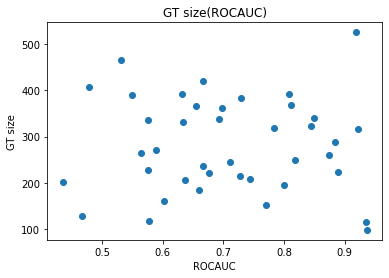

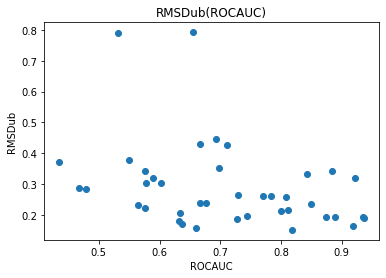

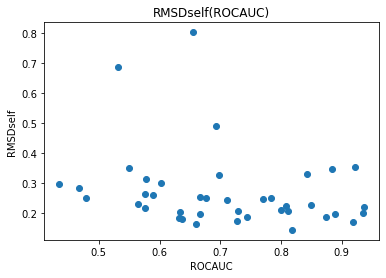

In [25]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.expanduser('~/masif_my/source'))

import my_utils as my

pdbs = list(my.chain_ids_table.keys())
dat_filename = 'rocauc_done.dat'

ids = []
ROCAUC_mean = []
ROCAUC_t_k = []
ROCAUC_t_k_err = []
GTsize_mean = []
GTsize_t_k = []
GTsize_t_k_err = []
GTsize_ROCAUC_R = []
RMSDub_mean = []
RMSDub_rocauc_R = []
RMSDself_mean = []
RMSDself_rocauc_R = []

with open(dat_filename, 'r') as data_file:
    data_line = data_file.readline()
    while(data_line):
        if(data_line[0] != '#'):
            data = data_line.split()
            for i in range(1, len(data)):
                data[i] = float(data[i])            
            
            ids.append(data[0])
            ROCAUC_mean.append(data[1])      # 8, 11, 14
            ROCAUC_t_k.append(data[2])
            ROCAUC_t_k_err.append(data[3])
            GTsize_mean.append(data[4])      # 7
            GTsize_t_k.append(data[5])
            GTsize_t_k_err.append(data[6])
            #GTsize_mean.append(data[])
            #rocauc_mean.append(data[])
            GTsize_ROCAUC_R.append(data[9])
            RMSDub_mean.append(data[10])
            #rocauc_mean.append(data[])
            RMSDub_rocauc_R.append(data[12])
            RMSDself_mean.append(data[13])
            #rocauc_mean.append(data[])
            RMSDself_rocauc_R.append(data[15])
        
        data_line = data_file.readline()
    
fig_ROCAUC_vs_GTsize, ax_ROCAUC_vs_GTsize = my.get_fig('ROCAUC', 'GT size')
ax_ROCAUC_vs_GTsize.scatter(ROCAUC_mean, GTsize_mean)

fig_ROCAUC_vs_RMSDub, ax_ROCAUC_vs_RMSDub = my.get_fig('ROCAUC', 'RMSDub')
ax_ROCAUC_vs_RMSDub.scatter(ROCAUC_mean, RMSDub_mean)

fig_ROCAUC_vs_RMSDself, ax_ROCAUC_vs_RMSDself = my.get_fig('ROCAUC', 'RMSDself')
ax_ROCAUC_vs_RMSDself.scatter(ROCAUC_mean, RMSDself_mean)